<a href="https://colab.research.google.com/github/inhovation97/personal_project/blob/main/pytorch/pytorch_project_ImageFolder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [4]:
device

'cuda'

# 데이터 분류
> 1. 원본 이미지를 다시 넘버링   
> 2. train/test split하여 파일 분류   
> 3. train/test 각각 다시 넘버링

In [5]:
# 원본 이미지 넘버링하기

import os
import glob

path = "/content/drive/MyDrive/파이토치/solo_project/original"
dolphin = glob.glob(path+"/dolphin" + '/*')
shark = glob.glob(path+"/shark"+'/*')
whale = glob.glob(path+"/whale"+'/*')


def rename(files):

  if 'dolphin' in files[0]:
     for i,f in enumerate(files):
         os.rename(f, os.path.join(path+"/dolphin", 'dolphin_' + '{0:03d}.jpg'.format(i)))
     dolphin = glob.glob(path+"/dolphin" + '/*')    
     print("dolphin {}번째 이미지까지 성공".format(i+1))

  elif 'shark' in files[0]:
     for i,f in enumerate(files):
         os.rename(f, os.path.join(path+"/shark", 'shark_' + '{0:03d}.jpg'.format(i)))
     shark = glob.glob(path+"/shark"+'/*')
     print("shark {}번째 이미지까지 성공".format(i+1))

  elif 'whale' in files[0]:
     for i,f in enumerate(files):
         os.rename(f, os.path.join(path+"/whale", 'whale_' + '{0:03d}.jpg'.format(i)))
     whale = glob.glob(path+"/whale"+'/*')
     print("whale {}번째 이미지까지 성공".format(i+1))


In [ ]:
# 이거 이미 완료했는데도 추가 실행하면 이미지가 쓰레기통 행으로 가버림(이유는 모르겠음)
#rename(dolphin)
#rename(shark)
#rename(whale)

In [6]:
# 이미지 리스트 정렬
dolphin = sorted(glob.glob(path+"/dolphin" + '/*'))
shark = sorted(glob.glob(path+"/shark"+'/*'))
whale = sorted(glob.glob(path+"/whale"+'/*'))

print('dolphin 이미지 개수: {}\nshark 이미지 개수: {}\nwhale 이미지 개수: {}'.format(len(dolphin), len(shark), len(whale)))

dolphin 이미지 개수: 373
shark 이미지 개수: 488
whale 이미지 개수: 451


In [7]:
whole_sum = len(dolphin)+len(shark)+len(whale)

print('전체 이미지 개수 : {}\n\ndolphin 이미지 비율 : {:.2f}%\nshark 이미지 비율 : {:.2f}%\ndolphin 이미지 비율 : {:.2f}%'.format( whole_sum, 100*len(dolphin)/whole_sum, 100*len(shark)/whole_sum, 100*len(whale)/whole_sum ))

전체 이미지 개수 : 1312

dolphin 이미지 비율 : 28.43%
shark 이미지 비율 : 37.20%
dolphin 이미지 비율 : 34.38%


#### 아주 약간 데이터가 imbalance하지만 이 정도는 크게 문제가 없어보임. 아마 fine tuning이 관건일 것 같음

# 정리한 이미지 시각화하기

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
%matplotlib inline

In [9]:
# cv2를 이용해 이미지를 읽는 함수 정의
def read_img(file_path):
    img_arr = cv2.imread(file_path)
    return cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB) # cvtColor로 BGR을 RGB로 바꿔줌

In [10]:
# 각 이미지 폴더에서 3개씩 랜덤으로 이미지 시각화 하기

# 이미지 array 준비
import random
img_arrs = []
img_num = range(0,300)

for i in random.sample(img_num,3):
    
    img_arrs.append(read_img(dolphin[i]))
    img_arrs.append(read_img(shark[i]))
    img_arrs.append(read_img(whale[i]))


In [11]:
print("총 {}개의 이미지 ".format(len(img_arrs)))

총 9개의 이미지 


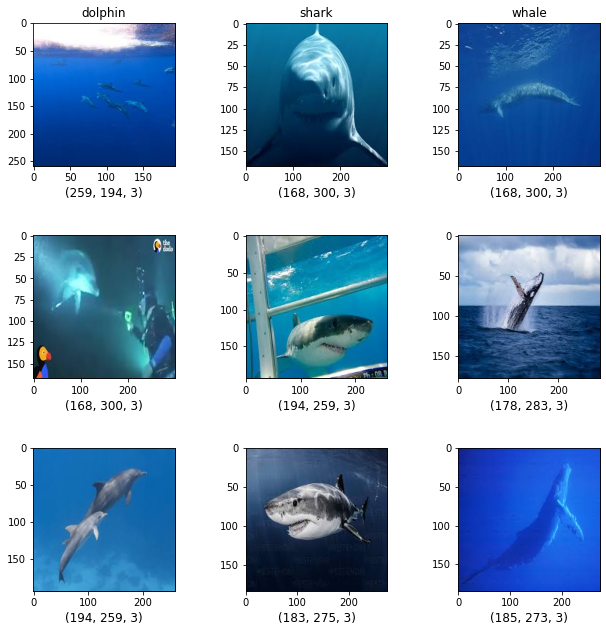

In [12]:
rows = 3 # 3개씩 샘플링 했으므로
columns = 3

# 그림판 설정
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))

# 각 판에 이미지 출력
for num in range(1, rows*columns+1): # 1번 부터 15번 까지
    
    fig.add_subplot(rows, columns, num) # 원하는 위치 번호(num)를 입력
    idx = num - 1 # 인덱스
    
    plt.imshow(img_arrs[idx], aspect='auto')
    plt.xlabel(f'{img_arrs[idx].shape}', fontsize=12)

fig.tight_layout() # 이미지 사이 간격 조정



# 제목 설정
cols = ['dolphin', 'shark', 'whale']

for folder_idx, ax in enumerate(axes[0]):
    ax.set_title(cols[folder_idx])

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

#### 역시 이미지들의 사이즈가 전부 다름.

# train/test split하기
> 데이터양이 적으므로 8:2 비율로 split   
> 사이킷런 같은 모듈로 나누는게 아니라 train/test 파일에 이미지를 복사해서 새 파일을 만들어야 한다.   
> 이미지를 8:2 비율로 랜덤으로 train/test에 파일을 복사하여 파일을 만들자.   

In [13]:
path = "/content/drive/MyDrive/파이토치/solo_project/original"
dolphin = sorted(glob.glob(path+"/dolphin" + '/*'))
shark = sorted(glob.glob(path+"/shark"+'/*'))
whale = sorted(glob.glob(path+"/whale"+'/*'))

print('dolphin 이미지 개수: {}\nshark 이미지 개수: {}\nwhale 이미지 개수: {}'.format(len(dolphin), len(shark), len(whale)))

dolphin 이미지 개수: 373
shark 이미지 개수: 488
whale 이미지 개수: 451


In [14]:
# 비율이 작은 test로 빠르게 split

import math

dolphin_test_count = round(len(dolphin)*0.2)
shark_test_count = round(len(shark)*0.2)
whale_test_count = round(len(whale)*0.2)

print('dolphin test파일에 들어갈 이미지 개수 : {}/{}'.format(dolphin_test_count,len(dolphin)))
print('shark test파일에 들어갈 이미지 개수 : {}/{}'.format(shark_test_count,len(shark)))
print('whale test파일에 들어갈 이미지 개수 : {}/{}'.format(whale_test_count,len(whale)))

dolphin test파일에 들어갈 이미지 개수 : 75/373
shark test파일에 들어갈 이미지 개수 : 98/488
whale test파일에 들어갈 이미지 개수 : 90/451


In [25]:
import shutil
def split( img_list, test_count, train_path, test_path):
  
  test_files=[]
  for i in random.sample( img_list, test_count ):
    test_files.append(i)

  # 차집합으로 train/test 리스트 생성하기
  train_files = [x for x in img_list if x not in test_files]

  for k in train_files:
    shutil.copy(k, train_path)
  
  for c in test_files:
    shutil.copy(c, test_path)

  print('train 폴더 이미지 개수 : {}\ntest 폴더 이미지 개수 : {}'.format(len(glob.glob(train_path+'/*')),len(glob.glob(test_path+'/*'))))

In [26]:
# 돌고래 파일
dolphin_train_path='/content/drive/MyDrive/파이토치/solo_project/train/dolphin'
dolphin_test_path='/content/drive/MyDrive/파이토치/solo_project/test/dolphin'

shark_train_path='/content/drive/MyDrive/파이토치/solo_project/train/shark'
shark_test_path='/content/drive/MyDrive/파이토치/solo_project/test/shark'

whale_train_path='/content/drive/MyDrive/파이토치/solo_project/train/whale'
whale_test_path='/content/drive/MyDrive/파이토치/solo_project/test/whale'

split(dolphin, dolphin_test_count, dolphin_train_path, dolphin_test_path)
split(shark, shark_test_count, shark_train_path, shark_test_path)
split(whale, whale_test_count, whale_train_path, whale_test_path)

train 폴더 이미지 개수 : 298
test 폴더 이미지 개수 : 75
train 폴더 이미지 개수 : 390
test 폴더 이미지 개수 : 98
train 폴더 이미지 개수 : 361
test 폴더 이미지 개수 : 90


#### 약 한 7분 정도 소요됨. 아마 넘파이 형태로 진행하면 훨씬 시간이 적게 걸릴 것임(폴더를 정리해야하기 때문에 이미지째로 진행)

# train/test로 split한 이미지들은 랜덤 추출했기 때문에 다시 넘버링 해주자.

In [34]:
# 원본 이미지 넘버링하기 -> rename 함수를 만들어줬으므로 경로만 바꿔서 재사용

# trainset 넘버링

path = "/content/drive/MyDrive/파이토치/solo_project/train"
dolphin = glob.glob(path+"/dolphin" + '/*')
shark = glob.glob(path+"/shark"+'/*')
whale = glob.glob(path+"/whale"+'/*')

rename(dolphin)
rename(shark)
rename(whale)

변경 전 trianset dolphin 13 번째 이름 : dolphin_013.jpg
변경 전 trianset shark 2 번째 이름 : dolphin_001.jpg
변경 전 trianset whale 1 번째 이름 : dolphin_000.jpg
dolphin 298번째 이미지까지 성공
shark 390번째 이미지까지 성공
whale 361번째 이미지까지 성공


In [45]:
path = "/content/drive/MyDrive/파이토치/solo_project/train"
dolphin = glob.glob(path+"/dolphin" + '/*')
shark = glob.glob(path+"/shark"+'/*')
whale = glob.glob(path+"/whale"+'/*')

print('각각 마지막 파일 이름 : ',os.path.basename(sorted(dolphin)[-1]), os.path.basename(sorted(shark)[-1]), os.path.basename(sorted(whale)[-1]))

마지막 파일 이름 :  dolphin_297.jpg shark_389.jpg whale_360.jpg


In [46]:
# testset 넘버링

path = "/content/drive/MyDrive/파이토치/solo_project/test"
dolphin = glob.glob(path+"/dolphin" + '/*')
shark = glob.glob(path+"/shark"+'/*')
whale = glob.glob(path+"/whale"+'/*')

rename(dolphin)
rename(shark)
rename(whale)

dolphin 75번째 이미지까지 성공
shark 98번째 이미지까지 성공
whale 90번째 이미지까지 성공


In [47]:
path = "/content/drive/MyDrive/파이토치/solo_project/test"
dolphin = glob.glob(path+"/dolphin" + '/*')
shark = glob.glob(path+"/shark"+'/*')
whale = glob.glob(path+"/whale"+'/*')

print('각각 마지막 파일 이름 : ',os.path.basename(sorted(dolphin)[-1]), os.path.basename(sorted(shark)[-1]), os.path.basename(sorted(whale)[-1]))

각각 마지막 파일 이름 :  dolphin_074.jpg shark_097.jpg whale_089.jpg
